## <a>**Required Imports**

In [ ]:
%%capture
!pip install fasttext

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import fasttext

## <a>**Load the Q&A Data**

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '18Nm_7itV325ApmW66ok2a9ENbISa0X-7'})
downloaded.GetContentFile('WikiQA-train.tsv')

downloaded = drive.CreateFile({'id': '1s8uBaTYpAgk_d2T2dvoYJSTjMw6_Xjun'})
downloaded.GetContentFile('WikiQA-test.tsv')

In [ ]:
df_train = pd.read_csv('WikiQA-train.tsv', sep="\t")
df_test = pd.read_csv('WikiQA-test.tsv', sep="\t")

In [ ]:
df_train[df_train["DocumentID"] == "D1001"].head(5)

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
7382,Q1038,when did the cold war start,D1001,Cold War,D1001-0,Photograph of the Berlin Wall taken from the W...,0
7383,Q1038,when did the cold war start,D1001,Cold War,D1001-1,The Wall was built in 1961 to prevent East Ger...,0
7384,Q1038,when did the cold war start,D1001,Cold War,D1001-2,It was an iconic symbol of the Cold War and it...,0
7385,Q1038,when did the cold war start,D1001,Cold War,D1001-3,"The Cold War, often dated from 1947 to 1991, w...",1
7386,Q1038,when did the cold war start,D1001,Cold War,D1001-4,This began after the success of their temporar...,0


In [ ]:
testing_Question = df_train[df_train["DocumentID"] == "D1"]["Question"][0]
print (testing_Question)

testing_sentence = df_train[df_train["DocumentID"] == "D1"]["Sentence"][0]
print (testing_sentence)

how are glacier caves formed?
A partly submerged glacier cave on Perito Moreno Glacier .


In [ ]:
# Split the test dataset to 50:50 validation and testing

from sklearn.model_selection import train_test_split
df_test, df_val = train_test_split(df_test,random_state=42, test_size=0.5, shuffle=True, stratify=df_test['Label'])

In [ ]:
df_train = df_train[['Question', 'Sentence', 'Label']]
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_val = df_val[['Question', 'Sentence', 'Label']]
df_val = df_val.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_test = df_test[['Question', 'Sentence', 'Label']]
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_val.shape

label_counts = df_test['Label'].value_counts()
label_counts

0    2912
1     146
Name: Label, dtype: int64

## <A>**Preprocess and Tokenize The Dataset using 3 Features**



##### Lemmatization


In [ ]:
# These are just common English contractions. We used it in Lab 5 before!
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


In [ ]:
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Preprocessing the data
def preprocess(sent_list, contraction_dict= contraction_dict):
    """
    This function takes a list of sentences and preprocesses each sentence.
    """
    output = []
    for sent in sent_list:
        sent= ' '.join(sent)
        sent = sent.lower() # case-folding
        for word, new_word in contraction_dict.items():
            sent = sent.replace(word, new_word) # dealing with contractions

        sent = re.sub(r'[^\w\s]','',sent) # removing punctuation

        tokens = word_tokenize(sent) # tokenization

        # lemmatization adapted from lab05
        lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens]
        output.append(lemma_sentence)

    return output

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


##### FastText-incorporated Word Embedding

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [ ]:
from gensim.models import FastText
import gensim.downloader as api

#Word embbedings dictionaries:
word_embedding_type = {1:"glove-wiki-gigaword-100", 2:'word2vec-google-news-100', 3:'fasttext-wiki-news-subwords-300'}

def word_embedding(sent_list, word_embedding_type_key = 1):

  # This function will take a list of words and return corresponding list of word vector
    word_emb_model_glove = api.load(word_embedding_type[word_embedding_type_key])
    ft_cbow_model = FastText(sent_list, vector_size=100, window=5, min_count=1, workers=2, sg=1)

    output = []
    for sent in sent_list:
        word_vector = []
        for word in sent:
            try:
                word_vector.append(word_emb_model_glove.get_vector(word))
            except KeyError:
                if ft_cbow_model is not None:
                    word_vector.append(ft_cbow_model.wv[word])
                else:
                    word_vector.append(np.zeros(word_emb_model_glove.vector_size, dtype='float32'))
        output.append(word_vector)
    return output



##### POS Tagging


In [ ]:
from nltk.tag import pos_tag

def pos_tagging(sentence_list):

  #This function will get tokenized words from preprocessing and will return array with corresponding tags
  output = []
  for sentence in sentence_list:

    tagged = pos_tag(sentence)
    result = []
    for key, item in tagged:
        result.append(item)
    output.append(result)

  return output

##### NER Tagging

In [ ]:
import spacy
import en_core_web_sm
from spacy import displacy

def NER(sentence_list):
  """
  This function will assign entity to each word in the world list after preporcessed.
  """
  nlp = en_core_web_sm.load()
  output =[]
  for word_list in sentence_list:
    entities = {}
    sentence = " ".join(word_list)

    # loading pre-trained model of NER

    sentence = nlp(sentence)

    for i in range(len(sentence.ents)):
      words = sentence.ents[i].text.split() # the text
      tag = sentence.ents[i].label_ # the NER tag
      for word in words:
          entities[word]=tag
    entities_list = []

    # wil allocatie entities if found in the entities otherwise it will allocate "O" which is other
    for word in word_list:
      if entities.get(word):
        entities_list.append(entities.get(word))
      else:
        entities_list.append("O")
    output.append(entities_list)
  return output


##### TF-IDF

In [ ]:
from collections import Counter
import math
import numpy as np

def tf_idf(sent_list):
  output = []
  DF = {}

  for sent in sent_list:
      #  Get each unique word in the doc - and count the number of occurrences in the document
      for term in np.unique(sent):
          try:
              DF[term] +=1
          except:
              DF[term] =1

  tf_idf = {}


  # total number of sentences
  N = len(sent_list)

  doc_id = 0
  # get each tokenised doc
  for sent in sent_list:
      tf_idf_amir = {}
      # initialise counter for the sent
      counter = Counter(sent)
      # calculate total number of words in the doc
      total_num_words = len(sent)

      # get each unique word in the doc
      for term in np.unique(sent):

          # calculate Term Frequency
          tf = counter[term]/total_num_words

          # calculate Document Frequency
          df = DF[term]

          # calculate Inverse Document Frequency
          idf = math.log(N/(df+1))+1

          # calculate TF-IDF

          tf_idf[doc_id, term] = tf*idf
          # Document for amir
          tf_idf_amir[term] = tf*idf
      sentence_word = []
      for word in sent:
        sentence_word.append(tf_idf_amir[word])

      output.append(sentence_word)

      doc_id += 1
  return output

##### Concatenating Features

In [ ]:
import numpy as np
import torch

def concatenation_features(sentence_list):
  """
  This function will concatinate the word vector created by the word_embeding(word)
  + pos(word) + ner(word) + tf-idf(word) and returns calculated average of all the word vectors in the sentence to obtain the sentence vector.

  Time: Takes 8mins for training, 3mins for validation, and 3mins for testing to run
  """
  output = []
  sentence_list= preprocess(sentence_list)
  word_wv = word_embedding(sentence_list)
  tf_idf_words = tf_idf(sentence_list)
  tagged_words = pos_tagging(sentence_list)
  tagged_words_wv = word_embedding(tagged_words)
  ner_words = NER(sentence_list)
  ner_words_wv = word_embedding(ner_words)

  for i in range(len(sentence_list)):
    sent = []

    for j in range(len(sentence_list[i])):
      concatenated_wv = np.concatenate((word_wv[i][j], tagged_words_wv[i][j], ner_words_wv[i][j]), axis=0)
      #concatenated_wv = np.append(concatenated_wv, tf_idf_words[i][j])
      sent.append(concatenated_wv)

    output.append(sent)
  return np.stack([np.mean(np.array(input_), axis=0) for input_ in output], axis=0)

In [ ]:
def get_preprocessed_tokenized_data(df):
  questions_ = concatenation_features([q.split() for q in df["Question"]])
  answers_ = concatenation_features([a.split() for a in df["Sentence"]])
  labels_ = df["Label"].values
  return questions_, answers_, labels_

#### **Apply the Function**

In [ ]:
#prints the preferred encoding for the current locale.

import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [ ]:
#always return "UTF-8" instead of the system's preferred encoding.

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# #mounting Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#update to your local drive to save the output array and not preprocess everytime

# %cp -r /content/drive/MyDrive/ColabNotebooks/embeddingsDataV2/ /content/

In [ ]:
questions_train, answers_train, labels_train  =  get_preprocessed_tokenized_data(df_train)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# # save the array to a file
# np.save('questions_train.npy', questions_train)
# np.save('answers_train.npy', answers_train)
# np.save('labels_train.npy', labels_train)

In [ ]:
# # load the array from the file
# questions_train = np.load('embeddingsDataV2/questions_train.npy')
# answers_train   = np.load('embeddingsDataV2/answers_train.npy')
# labels_train    = np.load('embeddingsDataV2/labels_train.npy')

In [ ]:
questions_train.shape, questions_train.shape, labels_train.shape

((20347, 300), (20347, 300), (20347,))

In [ ]:
questions_validation, answers_validation, labels_validation =  get_preprocessed_tokenized_data(df_val)

In [ ]:
# # save the array to a file
# np.save('questions_validation.npy', questions_validation)
# np.save('answers_validation.npy', answers_validation)
# np.save('labels_validation.npy', labels_validation)

In [ ]:
# # load the array from the file
# questions_validation = np.load('embeddingsDataV2/questions_validation.npy')
# answers_validation   = np.load('embeddingsDataV2/answers_validation.npy')
# labels_validation    = np.load('embeddingsDataV2/labels_validation.npy')

In [ ]:
questions_validation.shape, answers_validation.shape, labels_validation.shape

((3058, 300), (3058, 300), (3058,))

In [ ]:
questions_test, answers_test, labels_test =  get_preprocessed_tokenized_data(df_test)

In [ ]:
# # save the array to a file
# np.save('questions_test.npy', questions_test)
# np.save('answers_test.npy', answers_test)
# np.save('labels_test.npy', labels_test)

In [ ]:
# # load the array from the file
# questions_test = np.load('embeddingsDataV2/questions_test.npy')
# answers_test   = np.load('embeddingsDataV2/answers_test.npy')
# labels_test    = np.load('embeddingsDataV2/labels_test.npy')

In [ ]:
questions_test.shape, answers_test.shape, labels_test.shape

((3058, 300), (3058, 300), (3058,))

In [ ]:
# %cp -r /content/embeddingsDataV2 /content/drive/MyDrive/ColabNotebooks/

## <a>**Preprocess and Tokenize The Dataset Using a Single Feature**



In [ ]:
# import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # English

In [ ]:
# %cp -r /content/drive/MyDrive/ColabNotebooks/ /content/

In [ ]:
# fasttext_model = fasttext.load_model("cc.en.300.bin")

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# # Preprocess the data
# nltk.download('stopwords')
# stop_words = stopwords.words('english')

# def preprocess(text):
#     text = text.lower()
#     text = " ".join([word for word in text.split() if word not in stop_words])
#     text = "".join([char for char in text if char.isalnum() or char.isspace()])
#     return text

# # Tokenize the preprocessed text using FastText
# def tokenize(text):
#     return fasttext_model.get_sentence_vector(text)

# def get_preprocessed_tokenized_data(df):
#   questions_ = [preprocess(q) for q in df["Question"]]
#   questions_ = np.array([tokenize(q) for q in questions_])
#   answers_ = [preprocess(a) for a in df["Sentence"]]
#   answers_ = np.array([tokenize(a) for a in answers_])
#   labels_ = df["Label"].values

#   return questions_, answers_, labels_

In [ ]:
# questions_train, answers_train, labels_train                =  get_preprocessed_tokenized_data(df_train)
# questions_validation, answers_validation, labels_validation =  get_preprocessed_tokenized_data(df_val)
# questions_test, answers_test, labels_test                   =  get_preprocessed_tokenized_data(df_test)

## <a>**Create Dataloaders**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
class QADataset(Dataset):
    def __init__(self, questions, answers, labels):
        self.questions = questions
        self.answers = answers
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        question = self.questions[index]
        answer = self.answers[index]
        label = self.labels[index]
        return question, answer, label

In [ ]:
train_set = QADataset(questions_train, answers_train, labels_train)
val_set   = QADataset(questions_validation, answers_validation, labels_validation)
test_set  = QADataset(questions_test, answers_test, labels_test)

# Define your data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=32)
test_loader  = DataLoader(test_set, batch_size=32)

## <a>**Define the LSTM Model Architecture**

In [ ]:
#BiLSTM Model with attention

import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim, attn_type):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attn_type = attn_type

        if self.attn_type == "Dot Product":
            self.attn_func = self.dot_product_attention
        elif self.attn_type == "Scale Dot Product":
            self.attn_func = self.scale_dot_product_attention
        elif self.attn_type == "cosine_attention":
            self.attn_func = self.cosine_attention

        else:
            raise ValueError("Invalid attention type. Supported types: 'Dot Product', 'Scale Dot Product', 'cosine_attention'")

    def dot_product_attention(self, query, key, value):
        value1, value2 = value
        attn_weights = torch.matmul(query, key.transpose(-2, -1))
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_output1 = torch.matmul(attn_weights, value1)
        attn_output2 = torch.matmul(attn_weights, value2)
        attn_output = torch.cat((attn_output1, attn_output2), dim=1)
        return attn_output


    def scale_dot_product_attention(self, query, key, value):
        value1, value2 = value
        # Calculate the attention scores
        attn_weights = torch.matmul(query, key.transpose(-2, -1))
        attn_weights = attn_weights / torch.sqrt(torch.tensor(self.hidden_dim, dtype=torch.float32))
        attn_weights = F.softmax(attn_weights, dim=-1)

        # Apply the attention scores to each value tensor half
        attn_output1 = torch.matmul(attn_weights, value1)
        attn_output2 = torch.matmul(attn_weights, value2)
        attn_output = torch.cat((attn_output1, attn_output2), dim=1)
        return attn_output

    def cosine_attention(self, query, key, value):
        value1, value2 = value
        # Normalize query and key tensors
        query_norm = F.normalize(query, p=2, dim=-1)
        key_norm = F.normalize(key, p=2, dim=-1)
        # Calculate the cosine similarity between query and key
        similarity = torch.matmul(query_norm, key_norm.transpose(-2, -1))
        # Apply softmax to obtain attention weights
        attn_weights = F.softmax(similarity, dim=-1)

        # Apply the attention scores to each value tensor half
        attn_output1 = torch.matmul(attn_weights, value1)
        attn_output2 = torch.matmul(attn_weights, value2)
        attn_output = torch.cat((attn_output1, attn_output2), dim=1)
        return attn_output

    def forward(self, query, key, value):
        return self.attn_func(query, key, value)


class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, attn_type):
        super(LSTMModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Linear(embedding_dim, hidden_dim // 2)
        self.lstm1 = nn.LSTM(hidden_dim // 2, hidden_dim, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim // 2, hidden_dim, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 8, 1)
        self.sigmoid = nn.Sigmoid()
        self.attention = Attention(hidden_dim, attn_type)

    def forward(self, input1, input2):
        x1 = self.embedding(input1)
        x2 = self.embedding(input2)
        # Pass input1 through the first LSTM
        x1, _ = self.lstm1(x1.view(len(input1), 1, -1))
        # Pass input2 through the second LSTM
        x2, _ = self.lstm2(x2.view(len(input2), 1, -1))
        # Apply attention mechanism to the LSTM outputs
        attn_output = self.attention(x1, x2, (x1, x2))
        # Concatenate the outputs of the two LSTMs with attention
        x = torch.cat((x1.view(len(input1), -1), x2.view(len(input2), -1), attn_output.view(len(input1), -1)), dim=1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [ ]:
#BiLSTM Model without attention

# class LSTMModel(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim):
#         super(LSTMModel, self).__init__()
#         self.embedding_dim = embedding_dim
#         self.hidden_dim = hidden_dim
#         self.embedding = nn.Linear(embedding_dim, hidden_dim//2)
#         self.lstm1 = nn.LSTM(hidden_dim//2, hidden_dim, bidirectional=True)
#         self.lstm2 = nn.LSTM(hidden_dim//2, hidden_dim, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim*4, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, input1, input2):
#         x1 = self.embedding(input1)
#         x2 = self.embedding(input2)
#         # Pass input1 through the first LSTM
#         x1, _ = self.lstm1(x1.view(len(input1), 1, -1))
#         # Pass input2 through the second LSTM
#         x2, _ = self.lstm2(x2.view(len(input2), 1, -1))
#         # Concatenate the outputs of the two LSTMs
#         x = torch.cat((x1.view(len(input1), -1), x2.view(len(input2), -1)), dim=1)
#         x = self.fc(x)
#         x = self.sigmoid(x)
#         return x


In [ ]:
# Initialize your model and optimizer
model = LSTMModel(embedding_dim=300, hidden_dim=256, attn_type='Dot Product')
model.to('cuda')
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
num_epochs=20

## <a>**Training and Evaluating Code**

In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for questions, answers, labels in data_loader:
            questions = questions.clone().detach().float().to('cuda')  # convert input1 to Float tensor
            answers = answers.clone().detach().float().to('cuda')   # convert input2 to Float tensor
            labels = labels.clone().detach().float().to('cuda')
            output = model(questions, answers)
            loss = criterion(output.view(-1), labels)
            val_loss += loss.item()
            pred = torch.round(torch.sigmoid(output))
            correct += (pred.squeeze() == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(data_loader.dataset)
    val_acc = correct / total
    return val_loss, val_acc

In [ ]:
# define your training loop
best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for questions, answers, labels in train_loader:
        questions = questions.clone().detach().float().to('cuda')   # convert input1 to Float tensor
        answers = answers.clone().detach().float().to('cuda')   # convert input2 to Float tensor
        labels = labels.clone().detach().float().to('cuda')
        optimizer.zero_grad()
        output = model(questions, answers)
        loss = criterion(output.view(-1), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = torch.round(torch.sigmoid(output))

        correct += (pred.squeeze() == labels).sum().item()


        total += labels.size(0)
    train_loss /= len(train_loader.dataset)
    train_acc = correct / total

    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training finished.")


Epoch 1: train_loss=0.0239, train_acc=0.0511, val_loss=0.0218, val_acc=0.0474
Epoch 2: train_loss=0.0217, train_acc=0.0511, val_loss=0.0218, val_acc=0.0474
Epoch 3: train_loss=0.0217, train_acc=0.0511, val_loss=0.0218, val_acc=0.0474
Epoch 4: train_loss=0.0217, train_acc=0.0511, val_loss=0.0218, val_acc=0.0474
Epoch 5: train_loss=0.0217, train_acc=0.0511, val_loss=0.0218, val_acc=0.0474
Epoch 6: train_loss=0.0217, train_acc=0.0511, val_loss=0.0218, val_acc=0.0474
Epoch 7: train_loss=0.0217, train_acc=0.0516, val_loss=0.0218, val_acc=0.0491
Epoch 8: train_loss=0.0217, train_acc=0.1700, val_loss=0.0218, val_acc=0.2279
Epoch 9: train_loss=0.0217, train_acc=0.2812, val_loss=0.0218, val_acc=0.3041
Epoch 10: train_loss=0.0217, train_acc=0.3427, val_loss=0.0218, val_acc=0.3542
Epoch 11: train_loss=0.0217, train_acc=0.3880, val_loss=0.0218, val_acc=0.3944
Epoch 12: train_loss=0.0217, train_acc=0.4257, val_loss=0.0218, val_acc=0.4349
Epoch 13: train_loss=0.0217, train_acc=0.4558, val_loss=0.021

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.021760026405963185
Test Accuracy: 0.6258992805755396


In [ ]:
predsList, TrueList= [], []
with torch.no_grad():
    for questions, answers, labels in test_loader:
        questions = questions.clone().detach().float().to('cuda')  # convert input1 to Float tensor
        answers = answers.clone().detach().float().to('cuda')   # convert input2 to Float tensor
        labels = labels.clone().detach().float().to('cuda')
        output = model(questions, answers)
        loss = criterion(output.view(-1), labels)
        pred = torch.round(torch.sigmoid(output))
        predsList.extend(pred.squeeze().cpu().tolist())
        TrueList.extend(labels.cpu().tolist())

##### ***`Confusion Matrix`, `Classification Report` and `ROC AUC Curves`***

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt


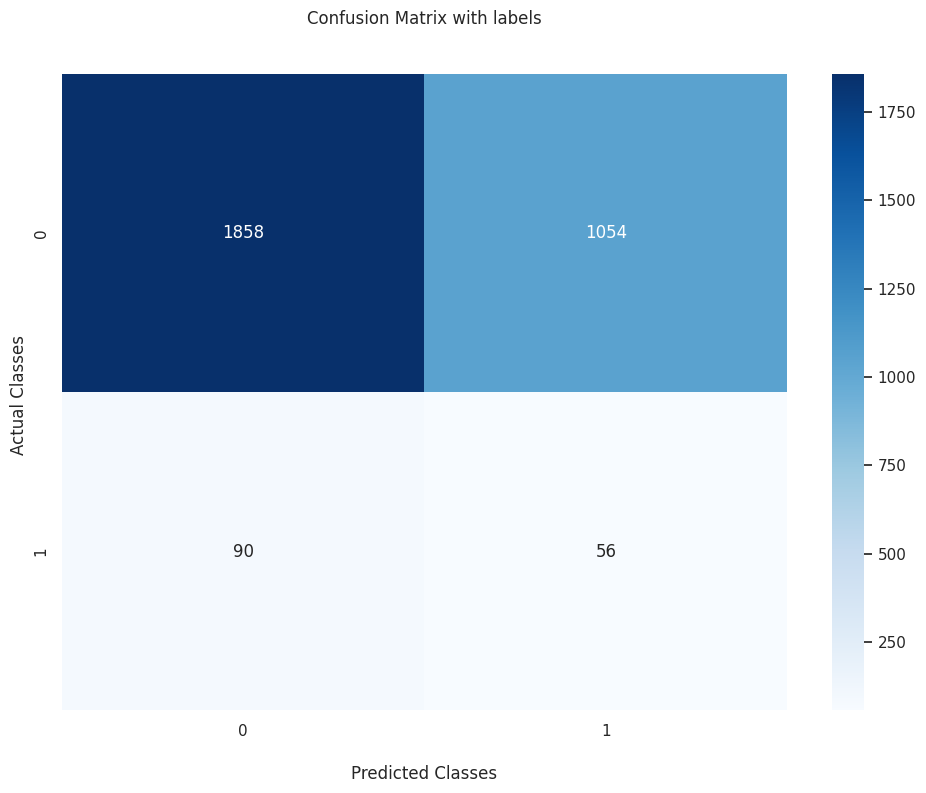

In [ ]:
confusionMatrix = confusion_matrix(TrueList, predsList)

ax = sns.heatmap(confusionMatrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Classes')
ax.set_ylabel('Actual Classes ');


## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print(classification_report(TrueList, predsList,zero_division=0))

              precision    recall  f1-score   support

         0.0       0.95      0.64      0.76      2912
         1.0       0.05      0.38      0.09       146

    accuracy                           0.63      3058
   macro avg       0.50      0.51      0.43      3058
weighted avg       0.91      0.63      0.73      3058



In [ ]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(TrueList, predsList)
print(f"ROC AUC: {score:.2f}")

ROC AUC: 0.51


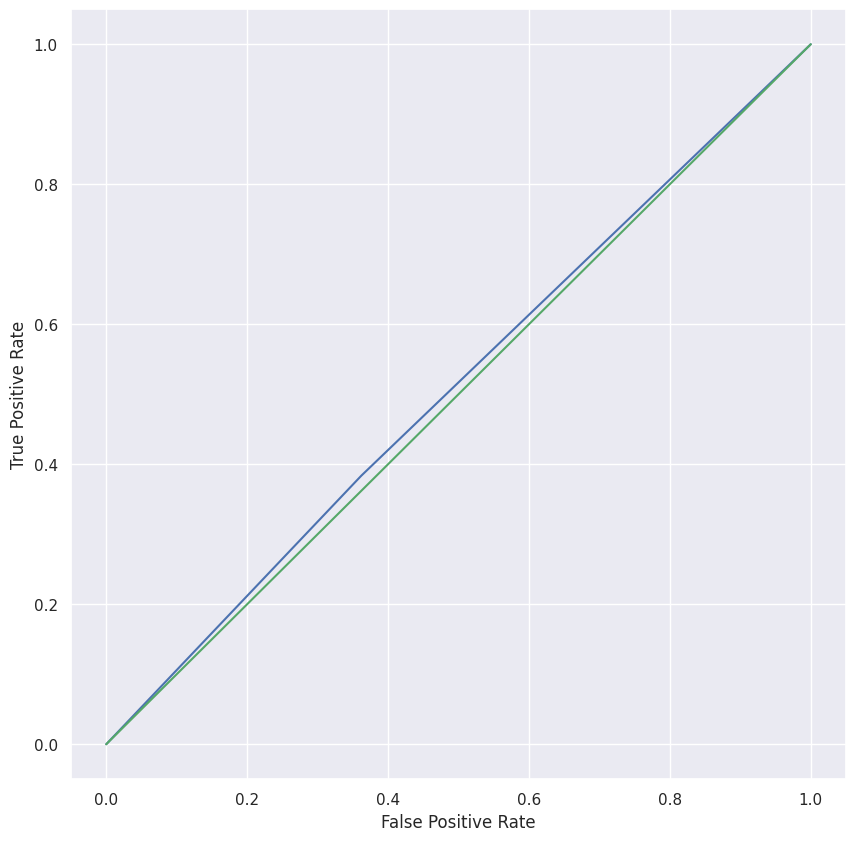

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(10,10)
    plt.plot([0, 1], [0, 1], color = 'g')

# Plots the ROC curve using the sklearn methods
plot_sklearn_roc_curve(TrueList, predsList)

In [ ]:
def predict_answer(model, question, candidate_answers):
    # Tokenize the question and candidate answers
    questions_ = concatenation_features([question.split()])

    answer_tokens = concatenation_features([a.split() for a in candidate_answers])

    # Convert the indices to PyTorch tensors
    question_tensor = torch.tensor(questions_)
    answer_tensors = [torch.tensor(indices).unsqueeze(0) for indices in answer_tokens]
    # Compute the scores for each candidate answer
    scores = []
    with torch.no_grad():
        for answer_tensor in answer_tensors:

            output = model(question_tensor.clone().detach().float().to('cuda'), answer_tensor.clone().detach().float().to('cuda'))
            score = torch.sigmoid(output).item()
            scores.append(score)
    # Return the candidate answer with the highest score
    return candidate_answers[np.argmax(scores)]


In [ ]:
model.eval()

question__ = "what causes heart disease?"
answers__ = ["Cardiovascular disease (also called heart disease) is a class of diseases that involve the heart or blood vessels ( arteries , capillaries , and veins ).",
           "Cardiovascular disease refers to any disease that affects the cardiovascular system , principally cardiac disease, vascular diseases of the brain and kidney , and peripheral arterial disease.",
           "The causes of cardiovascular disease are diverse but atherosclerosis and/or hypertension are the most common.",
           "Additionally, with aging come a number of physiological and morphological changes that alter cardiovascular function and lead to subsequently increased risk of cardiovascular disease, even in healthy asymptomatic individuals."]

ans= predict_answer(model, question__, answers__)

print(f"The predicted answer is: {ans}")


The predicted answer is: Cardiovascular disease refers to any disease that affects the cardiovascular system , principally cardiac disease, vascular diseases of the brain and kidney , and peripheral arterial disease.


In [ ]:
%cp -r /content/best_model.pth /content/drive/MyDrive/ColabNotebooks/

cp: cannot create regular file '/content/drive/MyDrive/ColabNotebooks/': No such file or directory


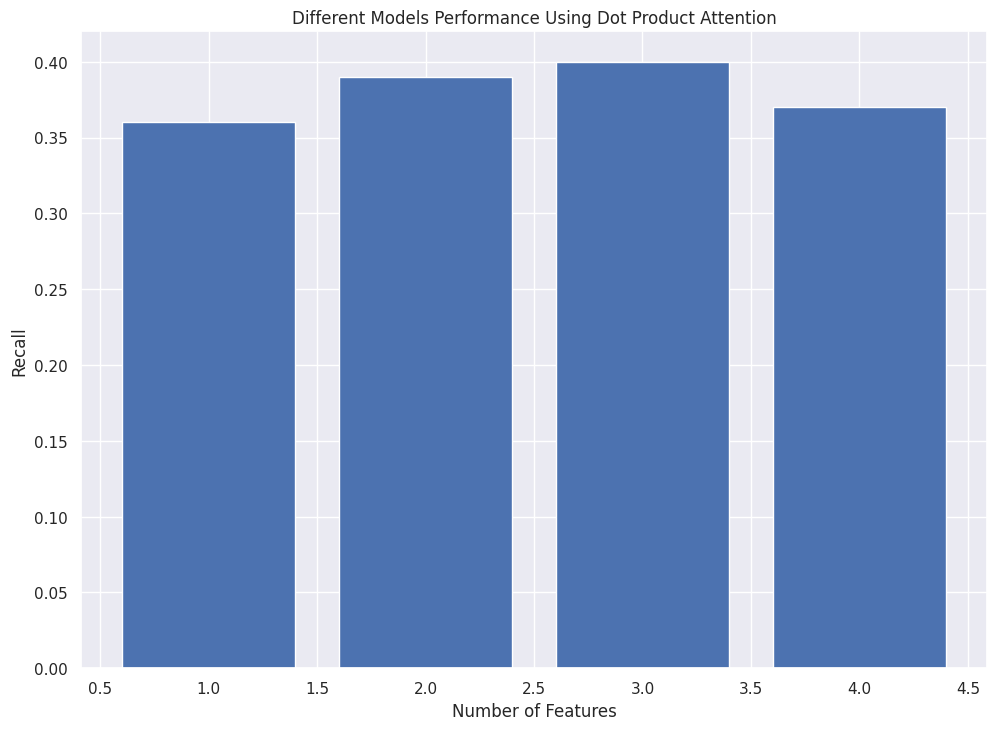

In [ ]:
import matplotlib.pyplot as plt

# Since dot product attention parameter is giving the optimum recall results, we fixed it for this evaluation across all models
# 1 feature = Word2vec
# 2 features = Word2vec + POS
# 3 features = Word2vec + POS + NER tag
# 4 features = Word2vec + POS + NER tag + TF-IDF

plt.title("Different Models Performance Using Dot Product Attention") # Set graph/figure title
plt.ylabel("Recall") # Set y-axis title
plt.xlabel("Number of Features") # Set x-axis title

Features = [1,2,3,4]
Recall = [0.36,0.39,0.40,0.37]
plt.bar(Features,Recall)

plt.show() # show the bar chart


In [ ]:
# In this sction we will compare the

from tabulate import tabulate
attention = ['Dot Product','Scale Dot Product','Cosine']
recall = [0.40,0.37,0.37]
table = [['']+['attention type: '+str(i) for i in attention], ['Recall']+recall]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════╤═══════════════════════════════╤═════════════════════════════════════╤══════════════════════════╕
│        │   attention type: Dot Product │   attention type: Scale Dot Product │   attention type: Cosine │
╞════════╪═══════════════════════════════╪═════════════════════════════════════╪══════════════════════════╡
│ Recall │                           0.4 │                                0.37 │                     0.37 │
╘════════╧═══════════════════════════════╧═════════════════════════════════════╧══════════════════════════╛


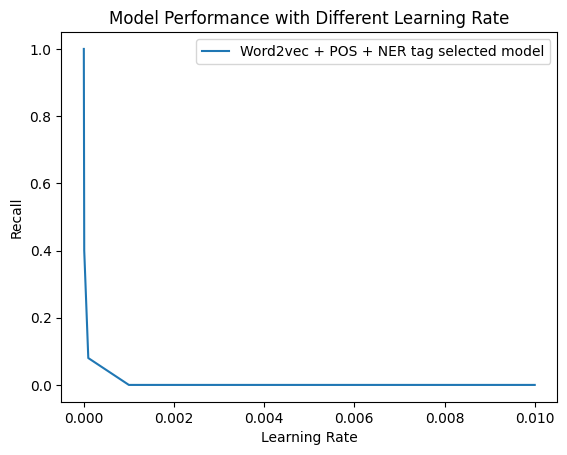

In [ ]:
import matplotlib.pyplot as plt
import random

plt.title("Model Performance with Different Learning Rate") # Set graph/figure title
plt.ylabel("Recall") # Set y-axis title
plt.xlabel("Learning Rate") # Set x-axis title

selected_models = ['Word2vec + POS + NER tag']

for selected_model in selected_models: # for each encoder variant, we will draw one line graph, showing the validation loss of each epoch
  lr = [0.000001, 0.00001, 0.0001, 0.001, 0.01] # for each variant, we apply 3 epochs. Thus, we will have epoch 1, 2, 3 (or 0, 1, 2 if you starts with 0)
  recall = [1, 0.4, 0.08, 0, 0] # for each epoch, we recorded the validation loss. Note that here we apply random numbers only for demonstration. However, you need to record your real validation loss if needed.
  plt.plot(lr,recall, label="{0} selected model".format(selected_model)) # label each line graph with the encoder number (see the actual plotting in the graph below)

plt.legend(); # this turns on the legends, which shows the label for each line graph. You can comment it out and rerun the code to see the difference
plt.show() # show the final figure

# More details of .plot() plotting can be found from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html